## CICIDS 2017
Preprocesamiento de los datos y cálculo de importancia de los parámetros

In [ ]:
#!/usr/bin/env python
# coding: utf-8


##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.


##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_data.csv) to make it easier to process.


import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"

# Nombres de los archivos CSV:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

# Etiquetas de cada columna
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels
main_labels=( ",".join( i for i in main_labels ) )
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r") as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# this line eliminates the headers of CSV files and incomplete streams .
                    #if " – " in str(line): ##  if there is "–" character ("–", Unicode code:8211) in the flow ,  it will be chanced with "-" character ( Unicode code:45).
                    #    line=(str(line).replace(" – "," - "))
                    line=(str(line).replace("inf","0"))
                    line=(str(line).replace("Infinity","0"))
                    
                    line=(str(line).replace("NaN","0"))
                     
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False)
    df=df.fillna(0)

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #Some data in the "Flow Bytes / s" and "Flow Packets / s" columns are not numeric. Fixing this bug in this loop
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # In this section, non-numeric (string and / or categorical) properties (columns) are detected.
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#The "Label" property was removed from the list. Because it has to remain "categorical" for using with different machine learning approach.
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder()



    for ii in string_features: ## In this loop, non-numeric (string and/or categorical) properties converted to numeric features.
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## Column 61 is deleted because it is unnecessary, column 41 ("Fwd Header Length" feature) had be mistakenly rewritten.



    ##Juntamos todos los archivos CSV en un mismo arvhivo:
    if flag:
        df.to_csv('all_data.csv' ,index = False)
        flag=False
    else:
        df.to_csv('all_data.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("El pre-procesamiento del archivo ",csv_files[i]," ha finalizado.\n")
    

print("Procesamiento finalizado")
print("Tiempo total de cálculo: = ",time.time()- seconds ,"seconds")
    


El pre-procesamiento del archivo  Monday-WorkingHours.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Tuesday-WorkingHours.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Wednesday-workingHours.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Friday-WorkingHours-Morning.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX  ha finalizado.

El pre-procesamiento del archivo  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX  ha finalizado.

Procesamiento finalizado
Tiempo total de cálculo: =  231.07123827934265 seconds


BENIGN                        2359289
DoS Hulk                       231073
PortScan                       158930
DDoS                            41835
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


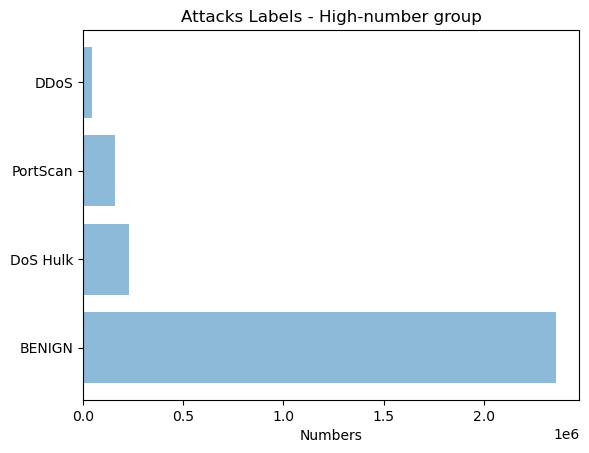

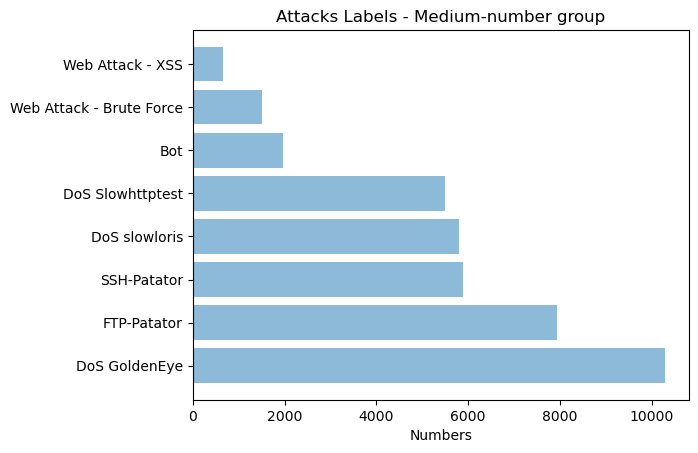

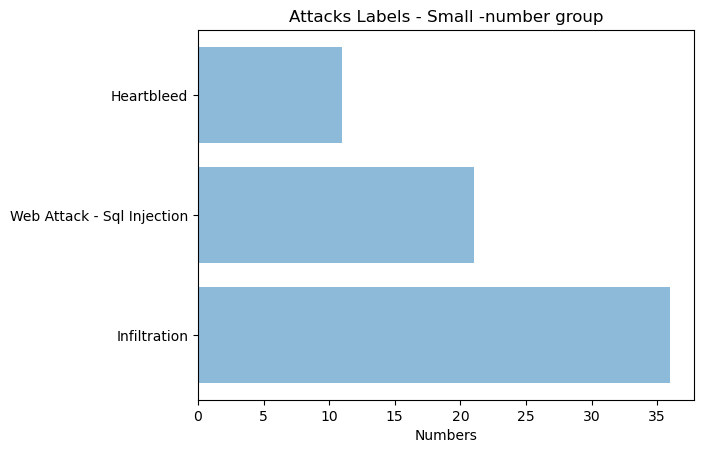

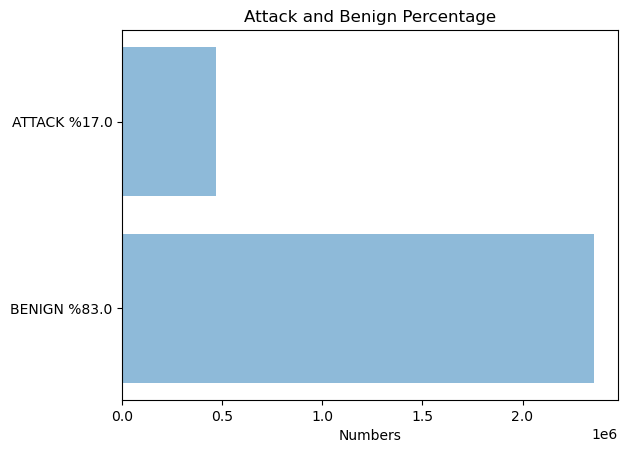

In [ ]:
#  Se requiere el archivo all_data.csv para la ejecución de este código.
#  El archivo all_data.csv debe estar ubicado en el mismo directorio que el programa.

#   El propósito de este programa es proporcionar estadísticas sobre los datos contenidos en el dataset.
#   Considerando que algunos de los datos son muy grandes y otros pequeños, los gráficos se van a separar en tres grupos para una mayor claridad:
#       big: etiquetas con más de 11000 apariciones
#       medium: etiquetas con entre 600 y 1100 apariciones
#       small: etiquetas con menos de 600 apariciones
#   En el último gráfico, se muestran las tasas de ataques y de tráfico normal


import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

#  Función para crear el gráfico
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('all_data.csv', usecols=["Label"]) #Leemos el archivo all_data.csv
print(df.iloc[:,0].value_counts()) #Mostramos por pantalla el numero de apariciones de cada ataque
a=(df.iloc[:,0].value_counts())


key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attack=0
benign=0


#   Clasificamos los ataques en los tres grupos anteriormente descritos:
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attack+=values[i]
        
key =[benign,attack]


#Llamamos a las funciones para crear las gráficas
labels=["BENIGN %"+str(round(benign/(benign+attack),2)*100),
        "ATTACK %"+str(round(attack/(benign+attack),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")

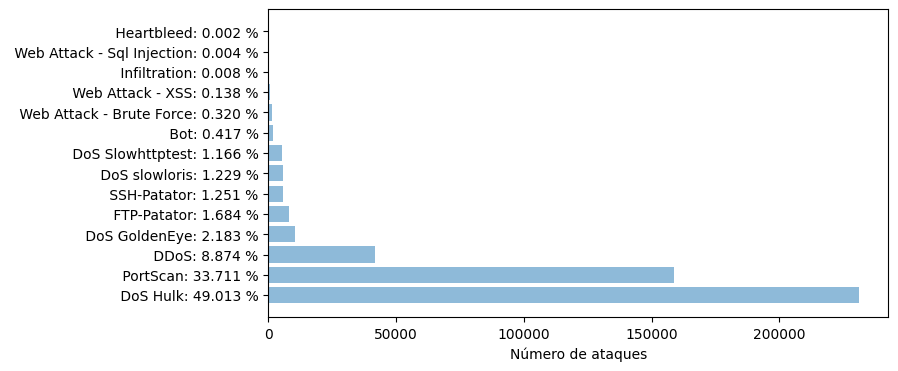

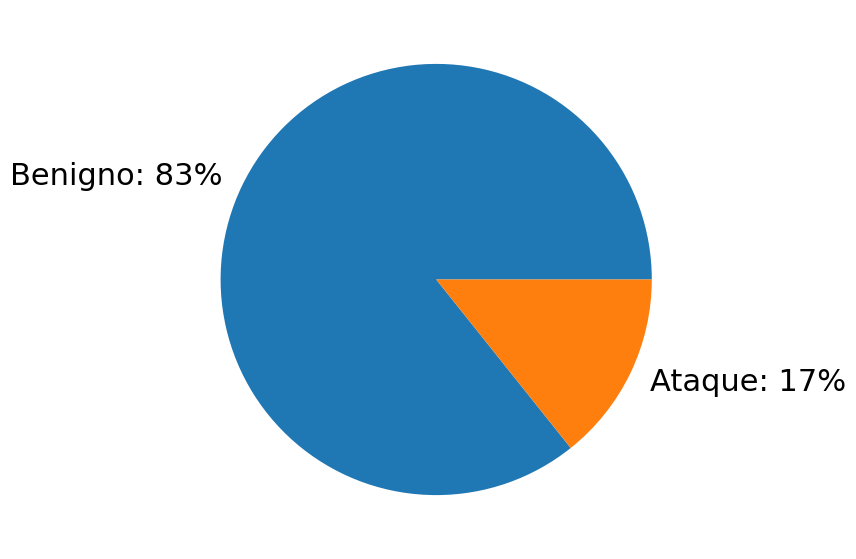

In [ ]:
##Código para obtener gráficas de las estadísticas

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

def graph(objects,performance,x_label,y_label):
    plt.figure(figsize = (8,4))
    y_pos = np.arange(len(objects))
    bars = plt.barh(y_pos, performance, align='center', alpha=0.5)
    #plt.bar_label(bars)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.show()

labels = ["DoS Hulk", "PortScan", "DDoS", "DoS GoldenEye", "FTP-Patator", "SSH-Patator", "DoS slowloris", "DoS Slowhttptest", "Bot",
           "Web Attack - Brute Force", "Web Attack - XSS", "Infiltration", "Web Attack - Sql Injection", "Heartbleed"]
values = [231073, 158930, 41835, 10293, 7938, 5897, 5796, 5499, 1966, 1507,652, 36, 21, 11]

total = 2830743
attacks = 2830743 - 2359289

ratio = [(i/attacks)*100 for i in values]

labels_ratio = [" %s: %.3f %%"% (labels[i], ratio[i]) for i in range(14)]
#print(ratio)

valores = { "BENIGN":2359289,
            "DoS Hulk":231073,
            "PortScan":158930,
            "DDoS" :41835,
            "DoS GoldenEye":10293,
            "FTP-Patator":7938,
            "SSH-Patator":5897,
            "DoS slowloris":5796,
            "DoS Slowhttptest":5499,
            "Bot":1966,
            "Web Attack - Brute Force":1507,
            "Web Attack - XSS":652,
            "Infiltration":36,
            "Web Attack - Sql Injection":21,
            "Heartbleed":11}


graph(labels_ratio,values,"Número de ataques","")


fig = plt.figure(figsize=(10, 7))
plt.pie([total, attacks], labels=['Benigno: 83%','Ataque: 17%'], textprops={'fontsize': 22})
 
# show plot
plt.show()

In [ ]:
#  Se requiere el archivo all_data.csv para la ejecución de este código.
#  El archivo all_data.csv debe estar ubicado en el mismo directorio que el programa.

# El objetivo de este programa es producir varios archivos CSV de forma que en cada uno solo haya ataques de un tipo y tráfico benigno.
# Estos archivos contienen todo el tráfico de ataque y algo de tráfico benigno (30% ataque, 70% benigno)
# El tráfico normal se selecciona aleatoriamente



import random
import os
import pandas as pd
import time
seconds = time.time()


def folder(f_name): #Crea un directorio llamado con nombre f_name
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("No se pudo crear el directorio")


# Etiquetas de cada columna:
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]
main_labels=( ",".join( i for i in main_labels ) )

attacks=["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris", "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator", "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"]
folder("./attacks/")

benign=2359289 #Numero de datos de tráfico normal/benigno

dict_attack={ #El valor del diccionario es el numero de ataques de cada tipo.
"Bot":1966,
"DDoS":41835,
"DoS GoldenEye":10293,
"DoS Hulk":231073,
"DoS Slowhttptest":5499,
"DoS slowloris":5796,
"FTP-Patator":7938,
"Heartbleed":11,
"Infiltration":36,
"PortScan":158930,
"SSH-Patator":5897,
"Web Attack - Brute Force":1507,
"Web Attack - XSS":652,
"Web Attack - Sql Injection":21}


# En esta sección se crea un archivo para cada tipo de ataque y se guarda en él el tráfico de dicho ataque junto con un flujo benigno aleatorio
for i in dict_attack:
    a,b=0,0 #b = numero de registros benignos, a = numero de ataques
    ths = open(".\\attacks\\"+i + ".csv", "w") #Abrimos/creamos el fichero correspondiente al ataque i
    ths.write(str(main_labels)+"\n") #Escribimos las etiquetas de los parámetros
    benign_num=int(benign/(dict_attack[i]*(7/3))) #70% benignos, 30% ataques
    with open("all_data.csv", "r") as file:
        while True: #Recorremos todo el fichero all_data.csv
            try:
                line=file.readline()    #Leemos línea a línea, cada registro de flujo
                line=line[:-1]          #Tomamos todos los caracteres menos el último (\n)
                k=line.split(",")       #Transforma la línea en una lista con los valores de los parámetros
                if k[83]=="BENIGN":     #Si el registro es benigno:
                    rnd=random.randint(1,benign_num) #Para evitar tomar siempre los benignos del principio, lo condicionamos con un numero aleatorio
                    if rnd==1:                       # y una probabilidad de (nºbenignos_requeridos/nºbenignos_total), que nos dará un 70-30
                            ths.write(str(line)+"\n")
                            b+=1
                if  k[83]==i: #Si es un ataque del tipo que estamos buscando, lo tomamos siempre:
                    ths.write(str(line)+"\n")
                    a+=1
                else:
                    continue                       
            except:
                break
    ths.close()
    print(i ,"fichero completado\n ataque:%d\n benigno:%d\n\n\n " %(a,b))

    
# Juntamos todos los ataques web en un único fichero:
webs=["Web Attack - Brute Force","Web Attack - XSS","Web Attack - Sql Injection"]
flag=True
for i in webs:
    df=pd.read_csv(".\\attacks\\"+str(i)+".csv")
    if flag:
        df.to_csv('.\\attacks\\Web Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('.\\attacks\\Web Attack.csv' ,index = False,header=False,mode="a")
    os.remove(".\\attacks\\"+str(i)+".csv")


print("Procesamiento completado")
print("Tiempo de operación: = ",time.time()- seconds ,"seconds")


Bot fichero completado
 ataque:1966
 benigno:4566


 
DDoS fichero completado
 ataque:41835
 benigno:98180


 
DoS GoldenEye fichero completado
 ataque:10293
 benigno:23897


 
DoS Hulk fichero completado
 ataque:231073
 benigno:589563


 
DoS Slowhttptest fichero completado
 ataque:5499
 benigno:13201


 
DoS slowloris fichero completado
 ataque:5796
 benigno:13302


 
FTP-Patator fichero completado
 ataque:7938
 benigno:18531


 
Heartbleed fichero completado
 ataque:11
 benigno:21


 
Infiltration fichero completado
 ataque:36
 benigno:82


 
PortScan fichero completado
 ataque:158930
 benigno:393537


 
SSH-Patator fichero completado
 ataque:5897
 benigno:13870


 
Web Attack - Brute Force fichero completado
 ataque:1507
 benigno:3426


 
Web Attack - XSS fichero completado
 ataque:652
 benigno:1469


 
Web Attack - Sql Injection fichero completado
 ataque:21
 benigno:38


 
Procesamiento completado
Tiempo de operación: =  596.2172560691833 seconds


Lista de relevancia de parámetros para el ataque tipo  Bot :
Bot 
                              importance
Features                               
Bwd Packet Length Mean         0.360206
Flow Duration                  0.011118
Flow IAT Max                   0.010515
Flow IAT Mean                  0.008170
Flow IAT Min                   0.006642
Flow IAT Std                   0.004260
Fwd IAT Total                  0.001397
Flow Bytes/s                   0.000804
Flow Packets/s                 0.000666
Bwd Packet Length Max          0.000394
Fwd Packet Length Mean         0.000381
Total Length of Bwd Packets    0.000318
Total Backward Packets         0.000210
Bwd Packet Length Std          0.000122
Fwd Packet Length Std          0.000070
Fwd Packet Length Max          0.000055
Total Length of Fwd Packets    0.000055
Total Fwd Packets              0.000044
Fwd Packet Length Min          0.000010
Bwd Packet Length Min          0.000003 



Bot=["Bwd Packet Length Mean","Flow Duration","Fl

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


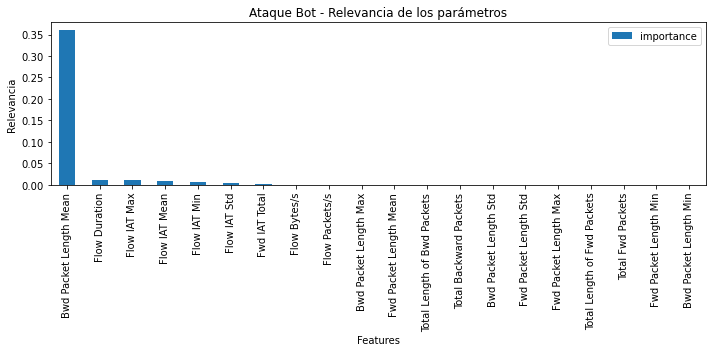

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  DDoS :
DDoS 
                              importance
Features                               
Bwd Packet Length Std          0.470069
Total Backward Packets         0.093654
Fwd IAT Total                  0.013253
Total Length of Fwd Packets    0.006444
Flow IAT Min                   0.006028
Flow Duration                  0.005928
Flow IAT Std                   0.005522
Flow IAT Mean                  0.005416
Flow Bytes/s                   0.004743
Flow IAT Max                   0.004642
Fwd Packet Length Max          0.002123
Flow Packets/s                 0.001030
Fwd Packet Length Std          0.000728
Bwd Packet Length Max          0.000647
Fwd Packet Length Mean         0.000479
Bwd Packet Length Min          0.000449
Bwd Packet Length Mean         0.000194
Total Length of Bwd Packets    0.000099
Total Fwd Packets              

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


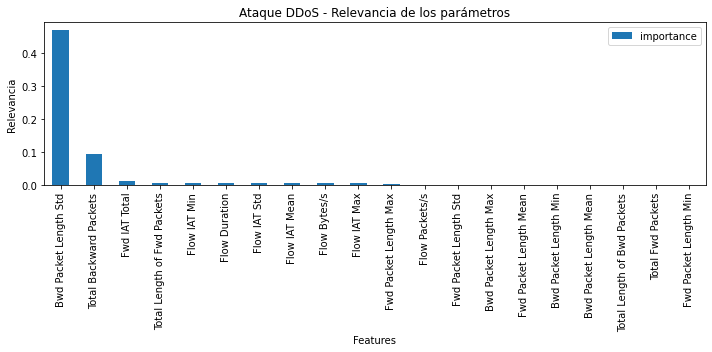

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  DoS GoldenEye :
DoS GoldenEye 
                              importance
Features                               
Flow IAT Max                   0.474878
Bwd Packet Length Std          0.058527
Total Backward Packets         0.046780
Flow IAT Min                   0.043043
Flow IAT Mean                  0.003036
Flow IAT Std                   0.002148
Bwd Packet Length Mean         0.001270
Fwd Packet Length Max          0.001244
Fwd Packet Length Min          0.001199
Flow Duration                  0.001182
Flow Bytes/s                   0.000922
Fwd IAT Total                  0.000871
Total Length of Fwd Packets    0.000442
Bwd Packet Length Max          0.000276
Flow Packets/s                 0.000211
Fwd Packet Length Mean         0.000168
Total Length of Bwd Packets    0.000146
Bwd Packet Length Min          0.000050
Total Fwd Pac

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


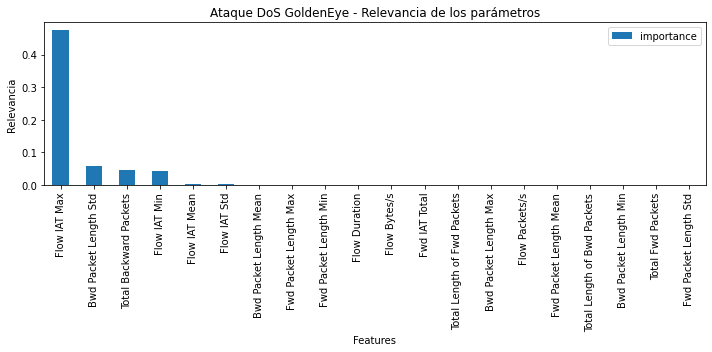

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  DoS Hulk :
DoS Hulk 
                                importance
Features                                 
Bwd Packet Length Std        5.146679e-01
Fwd Packet Length Std        7.388719e-02
Fwd Packet Length Max        4.256529e-03
Flow IAT Min                 2.005605e-03
Flow Duration                1.638425e-03
Total Backward Packets       3.508506e-04
Fwd IAT Total                2.067530e-04
Flow IAT Max                 1.372391e-04
Total Length of Bwd Packets  1.282891e-04
Flow IAT Mean                1.155876e-04
Flow Packets/s               9.161050e-05
Flow IAT Std                 3.582877e-05
Flow Bytes/s                 3.101402e-05
Bwd Packet Length Max        2.143281e-05
Bwd Packet Length Mean       1.869880e-05
Fwd Packet Length Mean       9.285329e-06
Total Length of Fwd Packets  9.093455e-06
Bwd Packet Length Min    

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


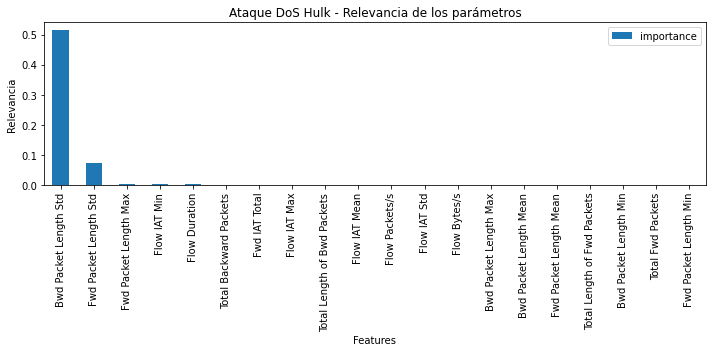

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  DoS Slowhttptest :
DoS Slowhttptest 
                              importance
Features                               
Flow IAT Mean                  0.645387
Fwd Packet Length Min          0.082083
Fwd Packet Length Std          0.018954
Fwd Packet Length Mean         0.017246
Bwd Packet Length Mean         0.016647
Total Length of Bwd Packets    0.012343
Bwd Packet Length Std          0.009863
Bwd Packet Length Max          0.004496
Flow IAT Min                   0.002060
Total Length of Fwd Packets    0.001039
Fwd Packet Length Max          0.000919
Total Fwd Packets              0.000772
Bwd Packet Length Min          0.000573
Flow Duration                  0.000510
Flow Bytes/s                   0.000474
Total Backward Packets         0.000417
Fwd IAT Total                  0.000342
Flow IAT Max                   0.000274
Flow IA

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


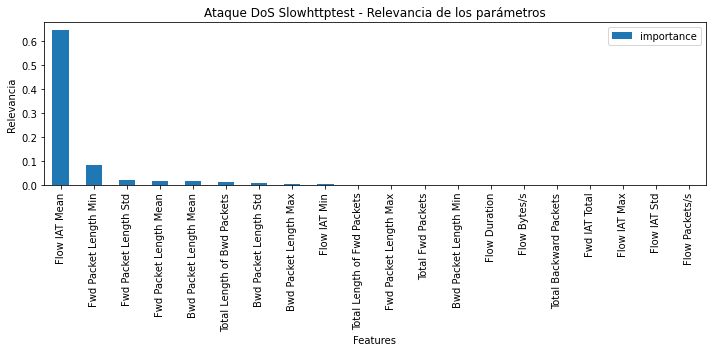

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  DoS slowloris :
DoS slowloris 
                              importance
Features                               
Flow IAT Mean                  0.474426
Bwd Packet Length Mean         0.100013
Total Length of Bwd Packets    0.019652
Total Fwd Packets              0.006356
Flow IAT Min                   0.002424
Flow Bytes/s                   0.001758
Bwd Packet Length Max          0.000968
Bwd Packet Length Std          0.000884
Flow IAT Max                   0.000807
Fwd Packet Length Std          0.000699
Fwd Packet Length Max          0.000694
Total Backward Packets         0.000666
Flow IAT Std                   0.000539
Fwd Packet Length Mean         0.000433
Flow Duration                  0.000319
Fwd Packet Length Min          0.000245
Fwd IAT Total                  0.000226
Total Length of Fwd Packets    0.000182
Flow Packets/

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


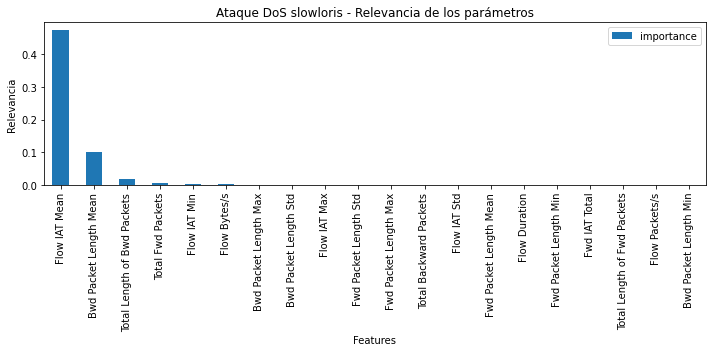

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  FTP-Patator :
FTP-Patator 
                              importance
Features                               
Fwd Packet Length Max          0.255835
Fwd Packet Length Std          0.027022
Fwd Packet Length Mean         0.010657
Bwd Packet Length Mean         0.000637
Total Fwd Packets              0.000458
Flow IAT Min                   0.000294
Bwd Packet Length Max          0.000261
Bwd Packet Length Std          0.000191
Total Length of Bwd Packets    0.000154
Fwd IAT Total                  0.000131
Flow Duration                  0.000124
Total Length of Fwd Packets    0.000121
Flow IAT Mean                  0.000094
Flow IAT Max                   0.000079
Flow IAT Std                   0.000068
Flow Packets/s                 0.000047
Total Backward Packets         0.000043
Fwd Packet Length Min          0.000016
Flow Bytes/s     

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


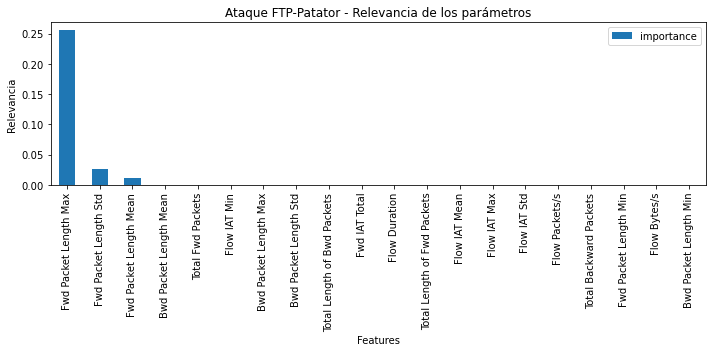

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  Heartbleed :
Heartbleed 
                              importance
Features                               
Bwd Packet Length Mean            0.052
Total Backward Packets            0.048
Total Length of Bwd Packets       0.048
Bwd Packet Length Max             0.040
Total Fwd Packets                 0.036
Total Length of Fwd Packets       0.032
Flow IAT Min                      0.032
Bwd Packet Length Std             0.028
Fwd Packet Length Max             0.020
Flow Duration                     0.016
Fwd IAT Total                     0.016
Flow IAT Std                      0.004
Fwd Packet Length Std             0.000
Fwd Packet Length Mean            0.000
Flow Bytes/s                      0.000
Flow Packets/s                    0.000
Flow IAT Mean                     0.000
Flow IAT Max                      0.000
Fwd Packet Length M

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


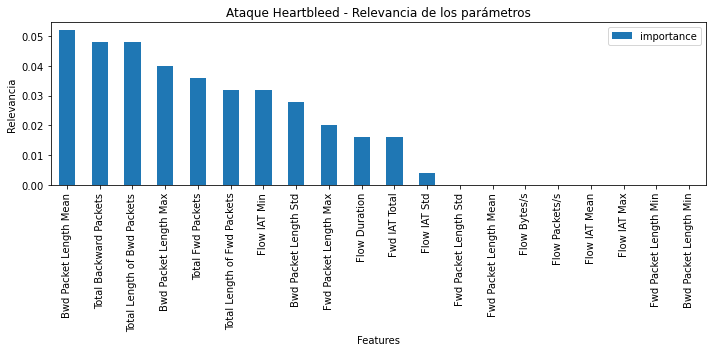

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  Infiltration :
Infiltration 
                              importance
Features                               
Fwd Packet Length Mean         0.224772
Total Length of Fwd Packets    0.062421
Fwd Packet Length Max          0.028231
Flow Duration                  0.022988
Flow IAT Std                   0.018528
Total Backward Packets         0.017390
Flow IAT Mean                  0.011898
Fwd Packet Length Std          0.009862
Flow Bytes/s                   0.008832
Fwd IAT Total                  0.007862
Flow IAT Min                   0.006825
Flow IAT Max                   0.003532
Flow Packets/s                 0.003299
Bwd Packet Length Mean         0.002072
Bwd Packet Length Min          0.001923
Fwd Packet Length Min          0.001691
Bwd Packet Length Max          0.001300
Bwd Packet Length Std          0.001246
Total Length of

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


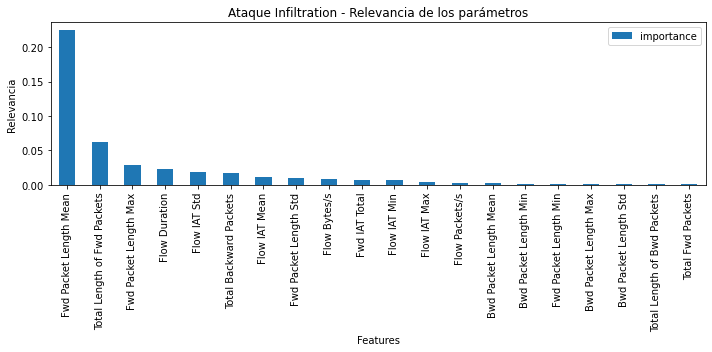

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  PortScan :
PortScan 
                              importance
Features                               
Flow Bytes/s                   0.313358
Total Length of Fwd Packets    0.304442
Flow IAT Max                   0.000255
Flow Duration                  0.000252
Flow IAT Mean                  0.000231
Fwd Packet Length Max          0.000177
Fwd IAT Total                  0.000130
Bwd Packet Length Min          0.000071
Total Length of Bwd Packets    0.000068
Bwd Packet Length Mean         0.000055
Flow Packets/s                 0.000046
Bwd Packet Length Max          0.000038
Flow IAT Std                   0.000027
Total Fwd Packets              0.000019
Bwd Packet Length Std          0.000017
Fwd Packet Length Mean         0.000014
Flow IAT Min                   0.000014
Total Backward Packets         0.000014
Fwd Packet Length Std  

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


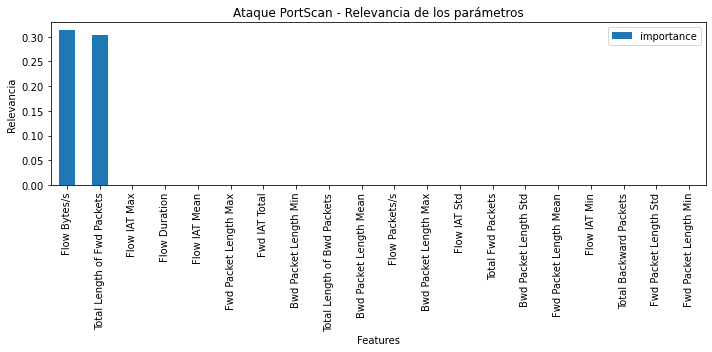

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  SSH-Patator :
SSH-Patator 
                              importance
Features                               
Fwd Packet Length Max          0.000931
Flow IAT Mean                  0.000642
Flow Duration                  0.000580
Flow IAT Max                   0.000544
Total Length of Fwd Packets    0.000484
Flow Bytes/s                   0.000441
Flow Packets/s                 0.000399
Bwd Packet Length Min          0.000324
Fwd IAT Total                  0.000268
Flow IAT Std                   0.000198
Fwd Packet Length Mean         0.000180
Fwd Packet Length Min          0.000127
Flow IAT Min                   0.000116
Bwd Packet Length Mean         0.000078
Bwd Packet Length Max          0.000075
Total Length of Bwd Packets    0.000067
Total Backward Packets         0.000057
Fwd Packet Length Std          0.000048
Total Fwd Packets

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


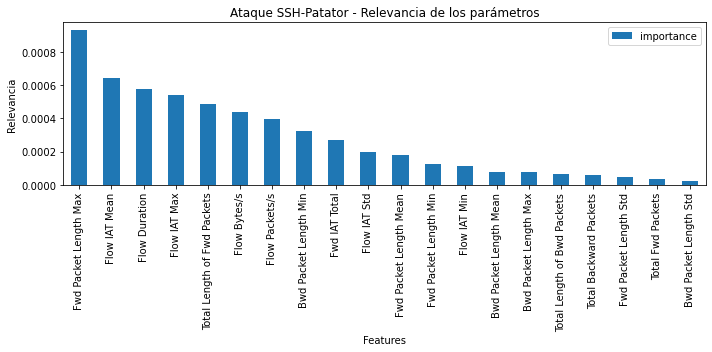

-----------------------------------------------------------------------------------------------




Lista de relevancia de parámetros para el ataque tipo  Web Attack :
Web Attack 
                              importance
Features                               
Bwd Packet Length Std          0.008407
Total Length of Fwd Packets    0.005940
Flow IAT Min                   0.004051
Flow Bytes/s                   0.002704
Bwd Packet Length Max          0.001307
Fwd Packet Length Std          0.000968
Fwd Packet Length Max          0.000693
Fwd Packet Length Mean         0.000525
Total Fwd Packets              0.000481
Flow Duration                  0.000480
Flow IAT Max                   0.000450
Flow IAT Mean                  0.000422
Flow Packets/s                 0.000369
Total Backward Packets         0.000368
Bwd Packet Length Mean         0.000146
Fwd IAT Total                  0.000145
Total Length of Bwd Packets    0.000135
Flow IAT Std                   0.000057
Bwd Packet Length M

C:\Users\pablo\AppData\Local\Temp\ipykernel_18560\3330131671.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')


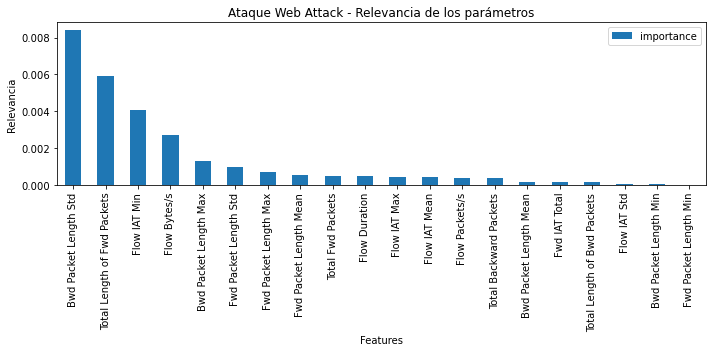

-----------------------------------------------------------------------------------------------




Procesamiento completado
Tiempo total de operación: =  5229.307070732117 segundos


In [ ]:
#  Se requiere el directorio "attacks" (con los archivos csv de los ataques) para la ejecución de este código.
#  El directorio "attacks" debe estar ubicado en el mismo directorio que el programa.

#   El objetivo de este código es determinar qué parámetros usar en la fase de aprendizaje automático
#   Para esto, se calculan los "pesos" en cuanto a importancia para cada parámetro y cada tipo de ataque
#   Este cálculo se hace usando klearn-RandomForestRegressor.


##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #Función que crea un directorio con nombre f_name (será feature_pics)
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("No se pudo crear el directorio")
        

# Nombres de los archivos CSV:
csv_files=os.listdir("attacks") # Crea una lista con cada nombre de ataque, a partir del directorio "attacks".

# Etiquetas de cada columna
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_for_attack_files.csv", "w") #Creamos el CSV que almacene todos los datos sobre la importancia de los parámetros
folder("./feaure_pics/")

for j in csv_files: #Para cada ataque:
    df=pd.read_csv(".\\attacks\\"+j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #Cambiamos la etiqueta normal a "1" y la de ataque a "0" para poder usar los datos con algoritmos de aprendizaje automático
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values


    #Calculamos las importancias de los parámetros:
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                    axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar()

    #Imprimimos las relevancias de los parámetros
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print("Lista de relevancia de parámetros para el ataque tipo ", j[0:-4],":")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title("Ataque " + j[0:-4] + " - Relevancia de los parámetros")
    plt.ylabel('Importancia')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("Procesamiento completado")
print("Tiempo total de operación: = ",time.time()- seconds ,"segundos")
ths.close()



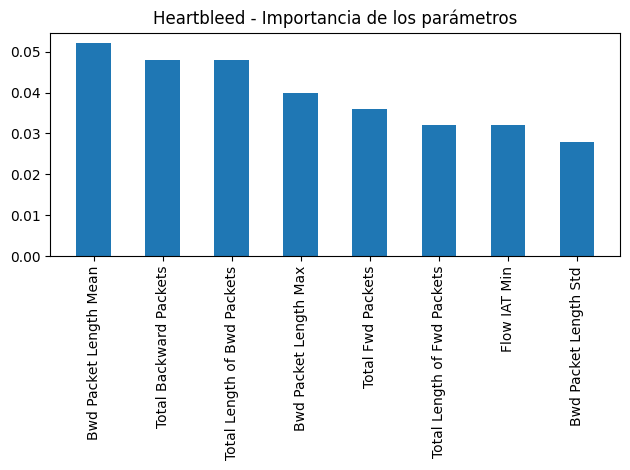

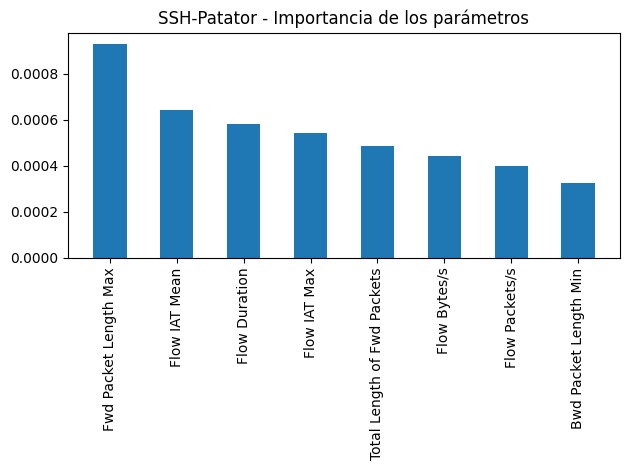

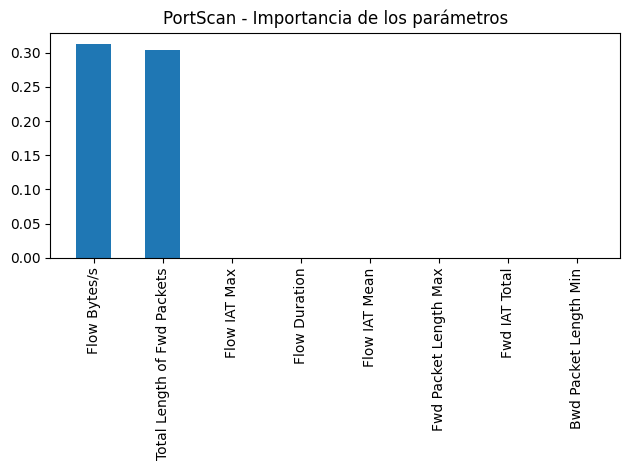

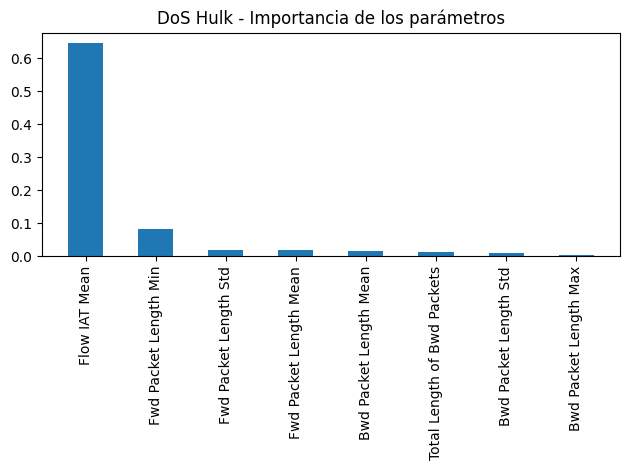

In [ ]:
#Para obtener las gráficas de la importancia de parámetros para los ejemplos en la memoria



####  NO INCLUIR ESTO EN LA MEMORIA --------------------------------------------------




import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time


Heartbleed={"Bwd Packet Length Mean":            0.052,
            "Total Backward Packets":            0.048,
            "Total Length of Bwd Packets":       0.048,
            "Bwd Packet Length Max":             0.040,
            "Total Fwd Packets":                 0.036,
            "Total Length of Fwd Packets":       0.032,
            "Flow IAT Min":                      0.032,
            "Bwd Packet Length Std":             0.028}

SSH_Patator={"Fwd Packet Length Max":         0.000931,
            "Flow IAT Mean":                  0.000642,
            "Flow Duration":                  0.000580,
            "Flow IAT Max":                   0.000544,
            "Total Length of Fwd Packets":    0.000484,
            "Flow Bytes/s":                   0.000441,
            "Flow Packets/s":                 0.000399,
            "Bwd Packet Length Min":          0.000324}

PortScan={  "Flow Bytes/s":                   0.313358,
            "Total Length of Fwd Packets":    0.304442,
            "Flow IAT Max":                   0.000255,
            "Flow Duration":                  0.000252,
            "Flow IAT Mean":                  0.000231,
            "Fwd Packet Length Max":          0.000177,
            "Fwd IAT Total":                  0.000130,
            "Bwd Packet Length Min":          0.000071}

DoS_Hulk={  "Flow IAT Mean":                  0.645387,
            "Fwd Packet Length Min":          0.082083,
            "Fwd Packet Length Std":          0.018954,
            "Fwd Packet Length Mean":         0.017246,
            "Bwd Packet Length Mean":         0.016647,
            "Total Length of Bwd Packets":    0.012343,
            "Bwd Packet Length Std":          0.009863,
            "Bwd Packet Length Max":          0.004496}

plt.title("Heartbleed - Importancia de los parámetros")
plt.bar(range(len(Heartbleed)), list(Heartbleed.values()), width=0.5, align='center')
plt.xticks(range(len(Heartbleed)), list(Heartbleed.keys()), rotation=90)
plt.tight_layout()
plt.show()

plt.title("SSH-Patator - Importancia de los parámetros")
plt.bar(range(len(SSH_Patator)), list(SSH_Patator.values()), width=0.5, align='center')
plt.xticks(range(len(SSH_Patator)), list(SSH_Patator.keys()), rotation=90)
plt.tight_layout()
plt.show()

plt.title("PortScan - Importancia de los parámetros")
plt.bar(range(len(PortScan)), list(PortScan.values()), width=0.5, align='center')
plt.xticks(range(len(PortScan)), list(PortScan.keys()), rotation=90)
plt.tight_layout()
plt.show()

plt.title("DoS Hulk - Importancia de los parámetros")
plt.bar(range(len(DoS_Hulk)), list(DoS_Hulk.values()), width=0.5, align='center')
plt.xticks(range(len(DoS_Hulk)), list(DoS_Hulk.keys()), rotation=90)
plt.tight_layout()
plt.show()

all_data importance list:
all_data 
                              importance
Features                               
Bwd Packet Length Std          0.246351
Flow Bytes/s                   0.178529
Total Length of Fwd Packets    0.117104
Fwd Packet Length Std          0.064064
Flow IAT Std                   0.009626
Flow IAT Min                   0.007102
Fwd IAT Total                  0.005040
Bwd Packet Length Max          0.004230
Flow Duration                  0.004029
Flow IAT Mean                  0.003401
Flow IAT Max                   0.003356
Total Length of Bwd Packets    0.001771
Fwd Packet Length Min          0.000642
Bwd Packet Length Mean         0.000560
Fwd Packet Length Mean         0.000558
Flow Packets/s                 0.000541
Fwd Packet Length Max          0.000157
Total Backward Packets         0.000116
Total Fwd Packets              0.000076
Bwd Packet Length Min          0.000051 



all_data=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets",

TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'papertype'

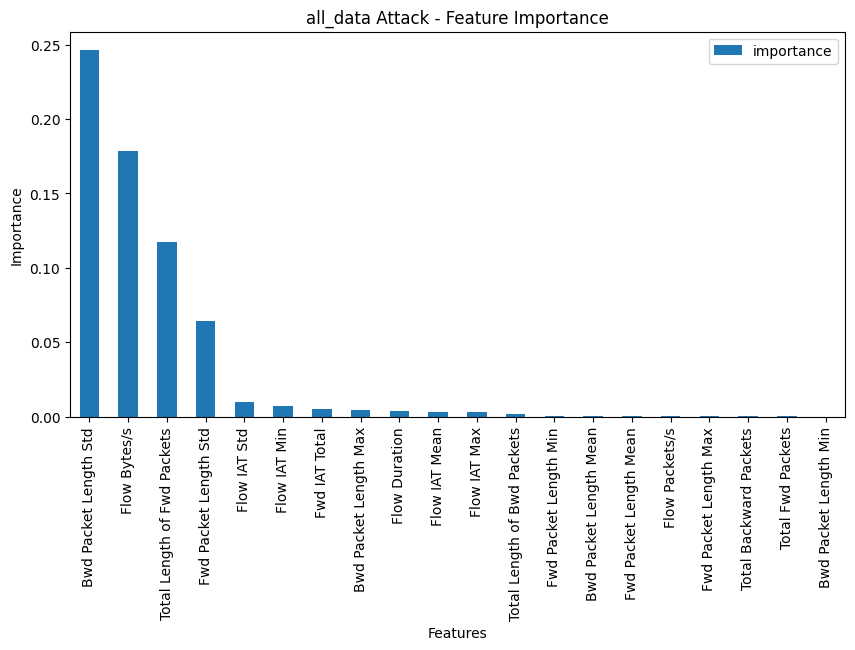

In [ ]:
#  Se requiere el archivo all_data.csv para la ejecución de este código.
#  El archivo all_data.csv debe estar ubicado en el mismo directorio que el programa.


#   El objetivo de este código es determinar qué parámetros usar en la fase de aprendizaje automático
#   Para esto, se calculan los "pesos" en cuanto a importancia para cada parámetro, para el conjunto gobal de ataques
#   Este cálculo se hace usando klearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): 
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# En este caso solo usamos el archivo all_data.csv:
csv_files=["all_data.csv"]

# Etiquetas de cada columna:
main_labels=["Flow Duration","Total Fwd Packets","Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_all_data.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv(j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#Cambiamos la etiqueta normal a "1" y la de ataque a "0" para poder usar los datos con algoritmos de aprendizaje automático
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   

    #Calculamos la importancia de cada parámetro:
    forest = sk.ensemble.RandomForestRegressor(n_estimators=10,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar()

    # Mostramos por pantalla las importancias de los parámetros
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+"Importancia de los parámetros sobre todo el dataset")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    #plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("Cálculo completado")
print("Tiempo total de operación: = ",time.time()- seconds ,"segundos")
ths.close()


usecols=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets",
"Fwd Packet Length Max","Bwd Packet Length Min",'Label']


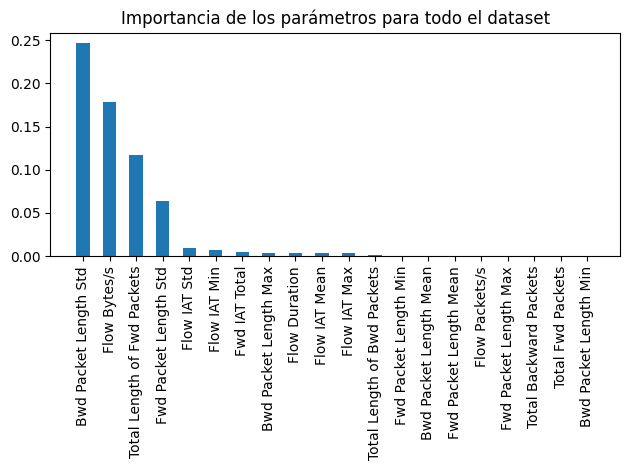

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time

all_importance = {  "Bwd Packet Length Std":          0.246351,
                    "Flow Bytes/s":                   0.178529,
                    "Total Length of Fwd Packets":    0.117104,
                    "Fwd Packet Length Std":          0.064064,
                    "Flow IAT Std":                   0.009626,
                    "Flow IAT Min":                   0.007102,
                    "Fwd IAT Total":                  0.005040,
                    "Bwd Packet Length Max":          0.004230,
                    "Flow Duration":                  0.004029,
                    "Flow IAT Mean":                  0.003401,
                    "Flow IAT Max":                   0.003356,
                    "Total Length of Bwd Packets":    0.001771,
                    "Fwd Packet Length Min":          0.000642,
                    "Bwd Packet Length Mean":         0.000560,
                    "Fwd Packet Length Mean":         0.000558,
                    "Flow Packets/s":                 0.000541,
                    "Fwd Packet Length Max":          0.000157,
                    "Total Backward Packets":         0.000116,
                    "Total Fwd Packets":              0.000076,
                    "Bwd Packet Length Min":          0.000051 }

plt.title("Importancia de los parámetros para todo el dataset")
plt.bar(range(len(all_importance)), list(all_importance.values()), width=0.5, align='center')
plt.xticks(range(len(all_importance)), list(all_importance.keys()), rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time

all_importance = {  "Bwd Packet Length Std":          0.246351,
                    "Flow Bytes/s":                   0.178529,
                    "Total Length of Fwd Packets":    0.117104,
                    "Fwd Packet Length Std":          0.064064,
                    "Flow IAT Std":                   0.009626,
                    "Flow IAT Min":                   0.007102,
                    "Fwd IAT Total":                  0.005040,
                    "Bwd Packet Length Max":          0.004230,
                    "Flow Duration":                  0.004029,
                    "Flow IAT Mean":                  0.003401,
                    "Flow IAT Max":                   0.003356,
                    "Total Length of Bwd Packets":    0.001771,
                    "Fwd Packet Length Min":          0.000642,
                    "Bwd Packet Length Mean":         0.000560,
                    "Fwd Packet Length Mean":         0.000558,
                    "Flow Packets/s":                 0.000541,
                    "Fwd Packet Length Max":          0.000157,
                    "Total Backward Packets":         0.000116,
                    "Total Fwd Packets":              0.000076,
                    "Bwd Packet Length Min":          0.000051 }

total_importance = sum(list(all_importance.values()))
all_rate = [i*100/total_importance for i in list(all_importance.values())]
print(all_rate)
print(sum(all_rate[0:7]))

[38.05800674798858, 27.580394992152062, 18.091036051067196, 9.897049917812959, 1.4870910731279274, 1.0971660919753314, 0.7786140669608098, 0.6534796633421083, 0.6224277928145044, 0.5254100082804989, 0.5184580969683488, 0.2735963318626179, 0.09918060138667456, 0.08651267410675663, 0.08620370027066108, 0.08357742266384884, 0.024254446133501414, 0.017920482493542444, 0.01174100577163126, 0.007878832820436766]
96.98935894108486
